# Project Milestone 3

NB : Our Milestone 2 is in another notebook. As our computations take a lot of time and we had started working in this notebook for milestone 3, we could not rerun the cells in this notebook in time.

### Imports

In [2]:
from sshtunnel import SSHTunnelForwarder # server communication
import psycopg2 # server connexion
import pandas as pd # dataframes
import matplotlib.pyplot as plt # graphs & visualizations
import numpy as np
import sklearn.cluster as skcl
import numpy as np
import networkx as nx
from numpy import genfromtxt

## Connect to database

In [3]:
server = SSHTunnelForwarder(
    ('ada-server.icefo.net',1022),
    ssh_username="datalore",
    ssh_password= "§8237t4rO8Q7349WZ8RHQIFNE928hqWOEHFVPU83Gwr8QG31803OQ4tv07",  # remove me
    remote_bind_address=('localhost', 5433),
    local_bind_address=('localhost', 5433)
)

server.start()

In [4]:
conn = psycopg2.connect(
    host="localhost",
    database="ada",
    user="datalore",  # Read only user
    password="DummyPasswd",
    port=5433)

## Start Analysis

In [5]:
# Get information on both top 200 channels
df_400 = pd.read_sql_query("select array_to_json(channel_ids) as channel_ids from links_betwenn_400_gaming_poli_channels_raw;", conn)

In [ ]:

# compute similarity matrix preprocessed table on remote database
def get_similirity_matrix_400(conn):

    matrix = np.zeros((400, 400), dtype=np.uintc)
    # matrix = [[0 for i in range(200)] for j in range(200)]
    row_id = 1
    total_len = len(df_400["channel_ids"])
    for row in df_400["channel_ids"]:
        row_len = len(row)
        for i in range(row_len):
            i_val = row[i]
            for j in range(i + 1, row_len):
                matrix[i_val][row[j]] += 1

        if row_id % 1_000_000 == 0:
            print(f"Processed {row_id} over {total_len} rows")
        row_id += 1

    return matrix

sim_matrix_400 = get_similirity_matrix_400(conn)

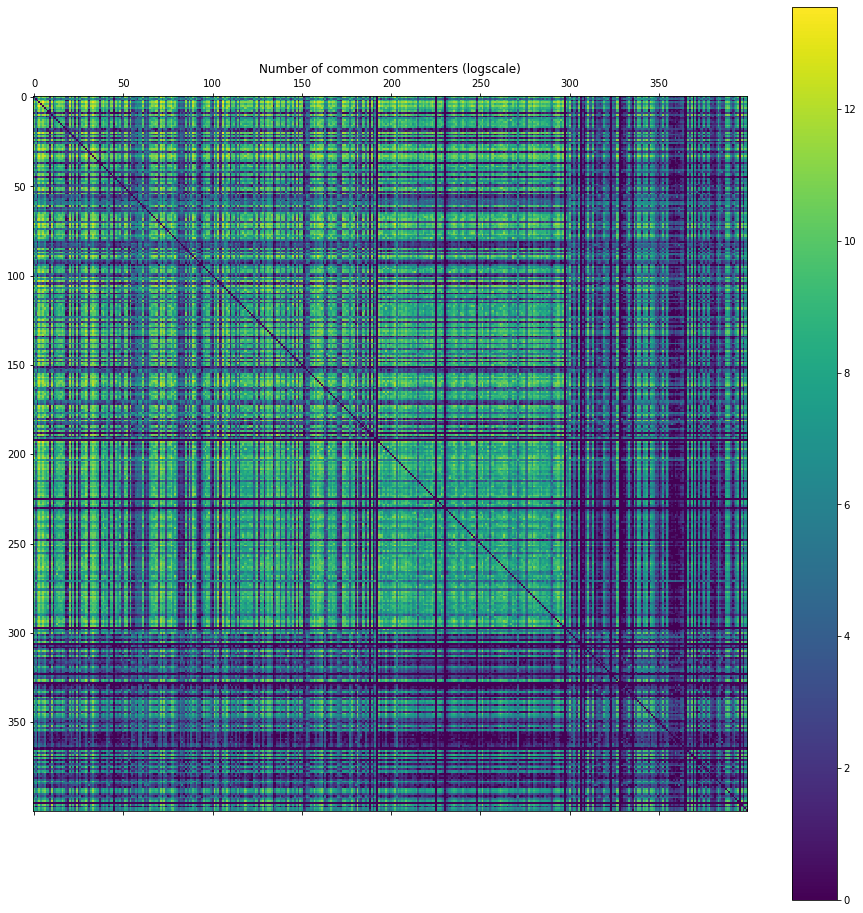

In [44]:
sim_matrix_400 = genfromtxt('sim_mat_400.csv', delimiter=',')
#create symmetric matrix from upper triangular
sim_matrix_400 = np.where(sim_matrix_400, sim_matrix_400, sim_matrix_400.T)

# normalize
#norm_sim = np.linalg.norm(sim_matrix)

# plot log similarity matrix
plt.matshow(np.log(sim_matrix_400 + 1))
plt.rcParams["figure.figsize"] = (50,50)
plt.colorbar()
plt.title('Number of common commenters (logscale)')
plt.show()

In [45]:
# print disconnected nodes
i = 0
for row in sim_matrix_400:
    all_zero = True
    for elem in row:
        if elem != 0:
            all_zero = False
    
    if all_zero:
        print(i)
    
    i += 1

192
225
297
328
395


In [8]:
#saving similarity matrix and df_400

df_400.to_csv("df_400.csv", index=False, sep=',')
np.savetxt("sim_mat_400.csv", sim_matrix_400, delimiter=',')

In [159]:
df_400 = pd.read_csv("df_400.csv",delimiter=',',)

In [14]:
df_400

'[5, 32, 34, 38, 52, 75, 79, 90, 103, 109, 112, 133, 136, 139, 140, 143, 156, 159, 175, 176, 189, 205, 211, 222, 243, 244, 257, 268, 270, 282]'

## Create initial nodes for 400

In [5]:
nodes_400 = pd.read_sql_query("Select index, join_date, name_cc, subscribers_cc, videos_cc, subscriber_rank_sb, weights as weights_r, category_e from most_pop_channels_400", con = conn)
nodes_400

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming
...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics


In [6]:
from numba import njit
from pandera.typing import Index, DataFrame, Series

In [ ]:

from numba import njit
from typing import List,Dict


count: Dict[int,int] = dict(zip(nodes_400.index, len(nodes_400)* [0]))
df_list: List[list]  = df_400.channel_ids.tolist()


def compute_counts():
    for b in df_list:
        for a in b:
            count[a] = count[a] + 1
    return count

commentator_by_channel_400 = compute_counts()

In [24]:
idx = commentator_by_channel_400.keys()
counts = [commentator_by_channel_400[i] for i in idx]
nodes_commentator_400 = pd.merge(nodes_400,pd.DataFrame({"index": idx, "commentator_count": counts}),on="index")

In [9]:
nodes_commentator_400.to_csv("nodes_commentator_400.csv", index=False)

In [160]:
nodes_commentator_400 = pd.read_csv("nodes_commentator_400.csv")

In [161]:
nodes_commentator_400

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics,30822
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582
...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


In [51]:
# get disconnected channels info
q = nodes_commentator_400.query("index == 192 | index == 225 | index == 297 | index == 328 | index == 395")[["name_cc", "category_e", "subscribers_cc", "videos_cc", "join_date"]]
q

,name_cc,category_e,subscribers_cc,videos_cc,join_date
192,SOMOY TV,News & Politics,3490000,35748,2015-10-21
225,Mastersaint,Gaming,3550000,59,2015-02-11
297,Jonni Valentayn,Gaming,2670000,204,2014-05-11
328,British Pathé,News & Politics,1090000,82232,2009-02-07
395,ABC News (Australia)...,News & Politics,722000,54363,2008-06-09


In [34]:
from lets_plot import * 
ggplot() + \
geom_point(aes(x="subscribers_cc", y="commentator_count", color="category_e"), data=nodes_commentator_400, sampling="none" if nodes_commentator_400.size < 2500 else sampling_systematic(n=2500)) + \
ggtitle("Chart") 

## Create edges for 400

In [162]:
sim_matrix_400 = genfromtxt('sim_mat_400.csv', delimiter=',')
print(sim_matrix_400.shape)

(400, 400)


In [163]:
edges_400 = pd.DataFrame(columns=['Source', 'Target', 'Weight'])
i = 0
for row in sim_matrix_400:
    j=0
    for val in row:
        if i <= j:
            if val != 0:
                edges_400 = edges_400.append({'Source': int(i), 'Target': int(j), 'Weight': int(val)}, ignore_index=True)
        j += 1
    
    i +=1

edges_400

,Source,Target,Weight
0,0,1,1091
1,0,2,15906
2,0,3,166477
3,0,4,15888
4,0,5,90434
...,...,...,...
70001,396,398,13882
70002,396,399,9345
70003,397,398,12
70004,397,399,3


In [164]:
edges_400.to_csv("edges_400.csv",index=False)

In [165]:
edges_400 = pd.read_csv("edges_400.csv")
edges_400

,Source,Target,Weight
0,0,1,1091
1,0,2,15906
2,0,3,166477
3,0,4,15888
4,0,5,90434
...,...,...,...
70001,396,398,13882
70002,396,399,9345
70003,397,398,12
70004,397,399,3



In the above statistics we can see that the median of shared connections is 290 which we will take as our threshold for considering the number of shared commenters as a connection

In [166]:
nodes_commentator_400 = pd.read_csv("nodes_commentator_400.csv",delimiter=',',)
nodes_commentator_400

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics,30822
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582
...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


## Computing the weights of the connections

In [168]:
weighted_400 = edges_400.merge(nodes_commentator_400[['index', 'name_cc', 'commentator_count']], left_on='Source', right_on='index', how='inner') \
    .drop(['index', 'name_cc'], axis=1) \
    .rename(columns={"commentator_count": "src_cnt"}) \
    .merge(nodes_commentator_400[['index', 'name_cc', 'commentator_count']], left_on='Target', right_on='index', how='inner') \
    .drop(['index', 'name_cc'], axis=1) \
    .rename(columns={"commentator_count": "tgt_cnt"})

weighted_400

,Source,Target,Weight,src_cnt,tgt_cnt
0,0,1,1091,414930,30822
1,0,2,15906,414930,194783
2,1,2,43,30822,194783
3,0,3,166477,414930,2443367
4,1,3,8991,30822,2443367
...,...,...,...,...,...
70001,321,369,1,5990,1
70002,330,369,1,448,1
70003,340,369,1,3221,1
70004,341,369,1,143984,1


In [169]:
weighted_400['avg_cnt'] = weighted_400[['src_cnt', 'tgt_cnt']].mean(axis=1)
weighted_400 = weighted_400.drop(['src_cnt', 'tgt_cnt'], axis=1)

weighted_400

,Source,Target,Weight,avg_cnt
0,0,1,1091,222876.0
1,0,2,15906,304856.5
2,1,2,43,112802.5
3,0,3,166477,1429148.5
4,1,3,8991,1237094.5
...,...,...,...,...
70001,321,369,1,2995.5
70002,330,369,1,224.5
70003,340,369,1,1611.0
70004,341,369,1,71992.5


In [170]:
weighted_400['Weight'] = weighted_400['Weight'] / weighted_400['avg_cnt']
weighted_400 = weighted_400.drop('avg_cnt', axis=1)

weighted_400

,Source,Target,Weight
0,0,1,0.004895
1,0,2,0.052175
2,1,2,0.000381
3,0,3,0.116487
4,1,3,0.007268
...,...,...,...
70001,321,369,0.000334
70002,330,369,0.004454
70003,340,369,0.000621
70004,341,369,0.000014


In [171]:
weighted_400.to_csv("weighted_edges_400.csv", index=False)

In [172]:
weighted_400 = pd.read_csv("weighted_edges_400.csv")

In [173]:
norm_sim_matrix_400 = np.zeros([400, 400])
norm_sim_matrix_400.fill(0)

for index, row in weighted_400.iterrows():
    i = int(row['Source'])
    j = int(row['Target'])
    norm_sim_matrix_400[i][j] = row['Weight']

print(norm_sim_matrix_400)

[[0.00000000e+00 4.89509862e-03 5.21753678e-02 ... 1.00653288e-03
  3.89877587e-02 2.04471310e-02]
 [0.00000000e+00 0.00000000e+00 3.81197225e-04 ... 0.00000000e+00
  2.48455096e-02 4.04062201e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.05829744e-05
  8.99468198e-03 3.66220371e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.93674975e-04 1.31380148e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.46449993e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


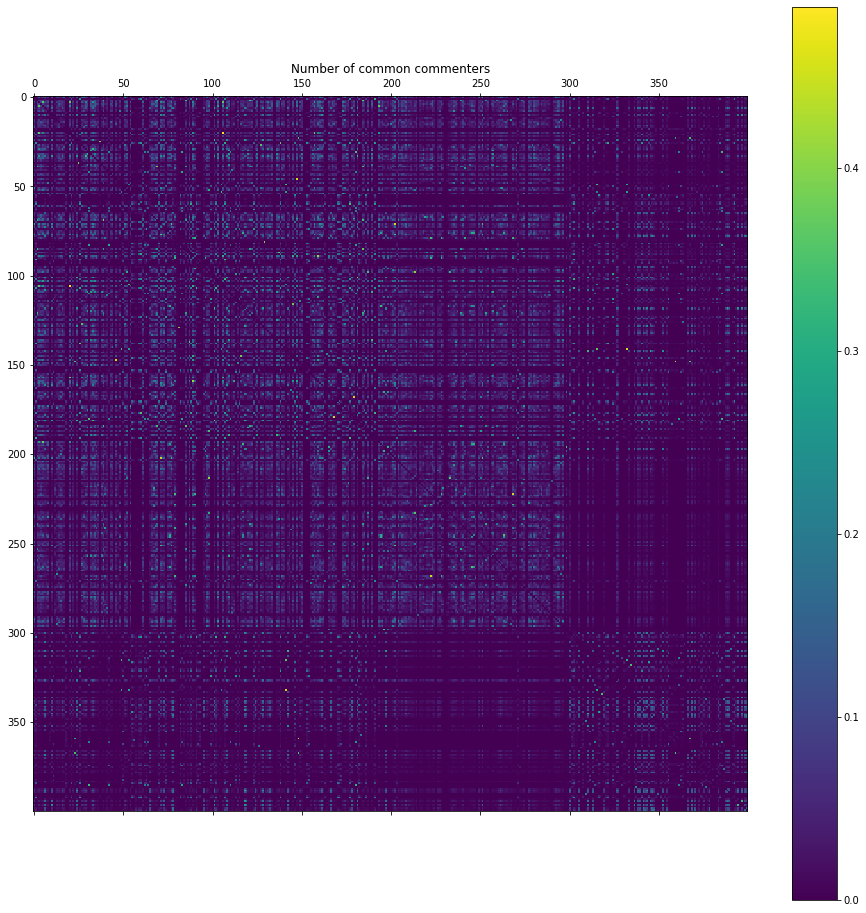

In [174]:
#create symmetric matrix from upper triangular
norm_sim_matrix_400 = np.where(norm_sim_matrix_400, norm_sim_matrix_400, norm_sim_matrix_400.T)

# plot log similarity matrix
plt.matshow(norm_sim_matrix_400)
plt.rcParams["figure.figsize"] = (50,50)
plt.colorbar()
plt.title('Number of common commenters')
plt.show()

In [175]:
clustering = skcl.SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_400)
labels_2_clusters_400 = clustering.labels_
labels_2_clusters_400

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
 0, 0, 0, 0], dtype=int32)

In [176]:
clustering = skcl.SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_400)
labels_3_clusters_400 = clustering.labels_
labels_3_clusters_400

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2,
 0, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 1, 2, 1, 0,
 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 0,
 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0,
 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0,
 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 2,
 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
 0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2,
 2, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1,
 2, 2, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2,
 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 2, 0, 1, 0, 2,
 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0,
 0, 0, 0, 0], dtype=int32)

In [177]:
clustering = skcl.SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_400)
labels_4_clusters_400 = clustering.labels_
labels_4_clusters_400

array([2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
 2, 0, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2,
 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 3, 0, 3, 2,
 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 3, 0, 2, 0, 2,
 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 0, 2, 2,
 3, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2,
 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0,
 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2,
 2, 0, 2, 2, 3, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0,
 0, 2, 2, 0, 0, 2, 3, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 3,
 0, 0, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0,
 2, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0,
 0, 2, 0, 2, 2, 0, 0, 3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2,
 2, 2, 2, 2], dtype=int32)

In [178]:
cl2 = pd.DataFrame(labels_2_clusters_400).reset_index().rename(columns={0: "two_clust"})
cl3 = pd.DataFrame(labels_3_clusters_400).reset_index().rename(columns={0: "three_clust"})
cl4 = pd.DataFrame(labels_4_clusters_400).reset_index().rename(columns={0: "four_clust"})

cluster_nodes_400 = nodes_commentator_400.merge(cl2, left_on='index', right_on='index', how='outer') \
    .merge(cl3, left_on='index', right_on='index', how='outer') \
    .merge(cl4, left_on='index', right_on='index', how='outer')

cluster_nodes_400

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,2
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics,30822,1,2,0
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,2
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,2
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0,0,0,2
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,2
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,2
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,0,2


In [179]:
cluster_nodes_400.to_csv("nodes_400.csv", index=False)

In [180]:

cluster_nodes = pd.read_csv("nodes_400.csv")
cluster_nodes

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,2
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics,30822,1,2,0
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,2
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,2
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0,0,0,2
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,2
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,2
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,0,2


In [181]:
conn_cnt_src = weighted_400['Source'].value_counts().reset_index()
conn_cnt_tgt = weighted_400['Target'].value_counts().reset_index()

degree_nodes_400 = cluster_nodes_400.merge(conn_cnt_src, left_on='index', right_on='index', how='outer') \
    .rename(columns={"Source": "src_deg"}) \
    .merge(conn_cnt_tgt, left_on='index', right_on='index', how='outer') \
    .rename(columns={"Target": "tgt_deg"}) \
    .fillna(0)

degree_nodes_400

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust,src_deg,tgt_deg
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,2,388.0,0.0
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics,30822,1,2,0,384.0,1.0
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,2,357.0,2.0
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,2,391.0,3.0
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,2,382.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0,0,0,2,0.0,0.0
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,2,3.0,383.0
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,2,2.0,264.0
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,0,2,1.0,386.0


In [182]:
degree_nodes_400['Degree'] = degree_nodes_400[['src_deg', 'tgt_deg']].sum(axis=1)
degree_nodes_400 = degree_nodes_400.drop(['src_deg', 'tgt_deg'], axis=1)

degree_nodes_400

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust,Degree
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,2,388.0
1,1,2013-01-07,Dhruv Rathee,2220000,185,3883,2.2845,News & Politics,30822,1,2,0,385.0
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,2,359.0
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,2,394.0
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,2,386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0,0,0,2,0.0
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,2,386.0
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,2,266.0
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,0,2,387.0


In [183]:
degree_nodes_400.to_csv("nodes_400.csv", index=False) #Save to use for the network graph
degree_nodes_400.to_csv("degree_nodes_400.csv", index=False) #Save as a checkpoint

# Result for 400

Ran on Gephi, and still clusters on language -> Get rid of most non-English

In [184]:
english_nodes = degree_nodes_400.query("two_clust == 0")
english_nodes

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust,Degree
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,2,388.0
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,2,359.0
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,2,394.0
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,2,386.0
5,5,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185,0,0,2,386.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,2008-06-09,ABC News (Australia)...,722000,54363,19359,2.8845,News & Politics,0,0,0,2,0.0
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,2,386.0
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,2,266.0
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,0,2,387.0


In [185]:
# Delete edges from and to nodes of other languages
english_weighted = weighted_400[weighted_400['Source'].isin(english_nodes['index'])]
english_weighted = english_weighted[english_weighted['Target'].isin(english_nodes['index'])]
english_weighted

,Source,Target,Weight
1,0,2,0.052175
3,0,3,0.116487
5,2,3,0.074270
6,0,4,0.042795
8,2,4,0.087479
...,...,...,...
69682,393,399,0.036659
69683,394,399,0.072078
69684,396,399,0.063714
69685,397,399,0.000131


In [186]:
english_weighted.to_csv("english_weighted_edges.csv", index=False)

In [187]:
# Get only nodes attached to the rest and clean previous clusters
english_nodes_attached = english_nodes[english_nodes['index'].isin(english_weighted['Source']) | english_nodes['index'].isin(english_weighted['Target'])]
english_nodes_attached = english_nodes_attached.drop(['two_clust', 'three_clust', 'four_clust', 'Degree'], axis=1)
english_nodes_attached

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930
2,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783
3,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367
4,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582
5,5,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185
...,...,...,...,...,...,...,...,...,...
394,394,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383
396,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
397,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
398,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


In [188]:
english_nodes_attached.to_csv("english_nodes_simple.csv", index=False)

In [189]:
english_nodes_attached = pd.read_csv("english_nodes_simple.csv")
english_nodes_new_indices = english_nodes_attached.reset_index(drop=True).reset_index()
english_nodes_new_indices

,level_0,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
0,0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930
1,1,2,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783
2,2,3,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367
3,3,4,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582
4,4,5,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185
...,...,...,...,...,...,...,...,...,...,...
266,266,394,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383
267,267,396,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
268,268,397,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
269,269,398,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


In [190]:
english_weighted = pd.read_csv("english_weighted_edges.csv")
english_weighted_new_indices = english_weighted.merge(english_nodes_new_indices[['index', 'level_0']], left_on='Source', right_on='index', how='inner')
english_weighted_new_indices = english_weighted_new_indices.drop(['index', 'Source'], axis=1).rename(columns={"level_0": "Source"})
english_weighted_new_indices = english_weighted_new_indices.merge(english_nodes_new_indices[['index', 'level_0']], left_on='Target', right_on='index', how='inner')
english_weighted_new_indices = english_weighted_new_indices.drop(['index', 'Target'], axis=1).rename(columns={"level_0": "Target"})

english_weighted_new_indices

,Weight,Source,Target
0,0.052175,0,1
1,0.116487,0,2
2,0.074270,1,2
3,0.042795,0,3
4,0.087479,1,3
...,...,...,...
36248,0.036659,265,270
36249,0.072078,266,270
36250,0.063714,267,270
36251,0.000131,268,270


In [191]:
norm_sim_matrix_english = np.zeros([271, 271])
norm_sim_matrix_english.fill(0)

for index, row in english_weighted_new_indices.iterrows():
    i = int(row['Source'])
    j = int(row['Target'])
    norm_sim_matrix_english[i][j] = row['Weight']

print(norm_sim_matrix_english)

[[0.00000000e+00 5.21753678e-02 1.16486845e-01 ... 1.00653288e-03
  3.89877587e-02 2.04471310e-02]
 [0.00000000e+00 0.00000000e+00 7.42702272e-02 ... 4.05829744e-05
  8.99468198e-03 3.66220371e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.35514335e-04
  2.04753075e-02 1.02385016e-02]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.93674975e-04 1.31380148e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.46449993e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


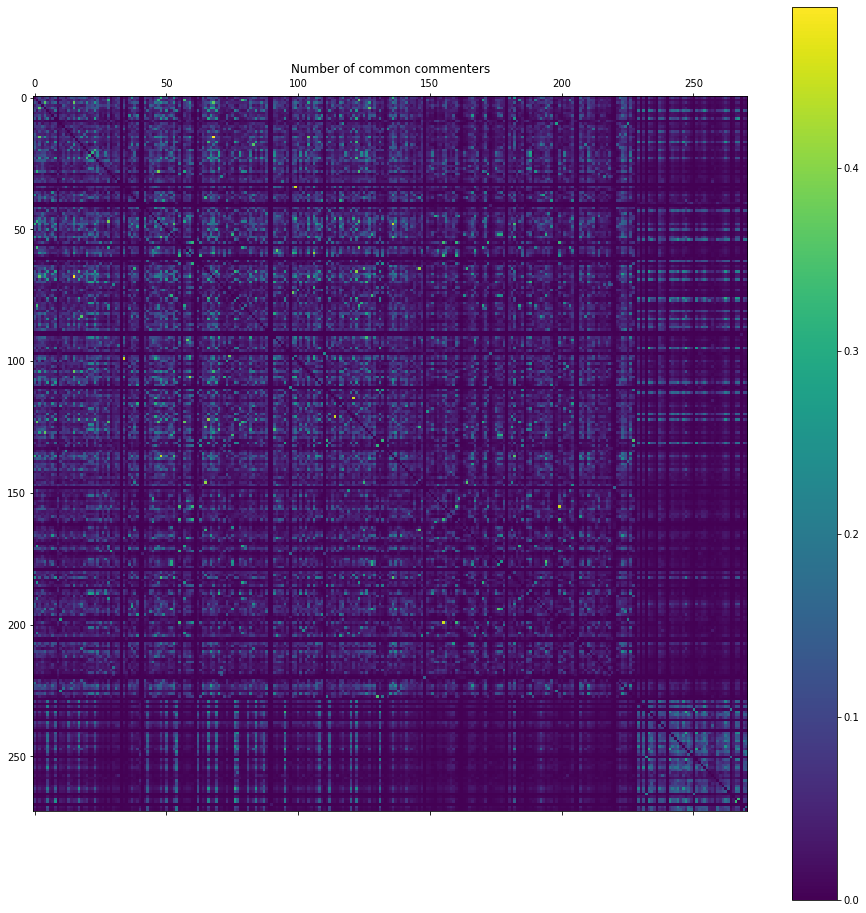

In [192]:
#create symmetric matrix from upper triangular
norm_sim_matrix_english = np.where(norm_sim_matrix_english, norm_sim_matrix_english, norm_sim_matrix_english.T)

# plot log similarity matrix
plt.matshow(norm_sim_matrix_english)
plt.rcParams["figure.figsize"] = (50,50)
plt.colorbar()
plt.title('Number of common commenters')
plt.show()

In [193]:
clustering = skcl.SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_english)
labels_2_clusters_english = clustering.labels_
labels_2_clusters_english

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [194]:
clustering = skcl.SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_english)
labels_3_clusters_english = clustering.labels_
labels_3_clusters_english

array([0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2,
 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 1, 2, 2, 2, 0, 2, 2], dtype=int32)

In [195]:
clustering = skcl.SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_english)
labels_4_clusters_english = clustering.labels_
labels_4_clusters_english

array([0, 0, 0, 0, 0, 3, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 3, 2, 0, 3,
 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 0, 0, 0, 0, 2, 3, 3, 2, 0, 0,
 3, 0, 0, 3, 0, 0, 2, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3,
 0, 2, 0, 0, 0, 2, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
 2, 2, 3, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 3,
 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2,
 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0,
 0, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3,
 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2,
 2, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
 1, 3, 3, 3, 0, 3, 3], dtype=int32)

In [196]:
cl2 = pd.DataFrame(labels_2_clusters_english).reset_index().rename(columns={0: "two_clust"})
cl3 = pd.DataFrame(labels_3_clusters_english).reset_index().rename(columns={0: "three_clust"})
cl4 = pd.DataFrame(labels_4_clusters_english).reset_index().rename(columns={0: "four_clust"})

cluster_nodes_english = english_nodes_new_indices.merge(cl2, left_on='level_0', right_on='index', how='outer') \
    .merge(cl3, left_on='level_0', right_on='index', how='outer') \
    .merge(cl4, left_on='level_0', right_on='index', how='outer')

cluster_nodes_english = cluster_nodes_english.drop(['index_x', 'index_y'], axis=1).rename(columns={"level_0": "index"})

cluster_nodes_english

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,0
1,1,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,0
2,2,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,0
3,3,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,0
4,4,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383,0,2,3
267,267,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,2,3
268,268,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,0
269,269,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,2,3


In [197]:
cluster_nodes_english.to_csv("english_nodes_clustered.csv", index=False)

In [198]:
english_weighted_new_indices.to_csv("english_edges_clustered.csv", index=False)

# Result english clusters

In [203]:
cluster_nodes_english = pd.read_csv("english_nodes_clustered.csv")
q = cluster_nodes_english.query("two_clust == 1")[["name_cc", "category_e", "subscribers_cc", "videos_cc"]]
q

,name_cc,category_e,subscribers_cc,videos_cc
232,Kenya CitizenTV,News & Politics,1280000,86289
250,KTN News Kenya,News & Politics,933408,116878
264,K24 TV,News & Politics,753000,71034


--> new location : Kenya


# Continue recursive search

In [201]:
english_nodes = cluster_nodes_english.query("two_clust == 0")
english_nodes

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,0,0,0
1,1,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,0,0,0
2,2,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,0,0,0
3,3,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,0,0,0
4,4,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
266,266,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383,0,2,3
267,267,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,2,3
268,268,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,0
269,269,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,2,3


In [202]:
# Delete edges from and to nodes of other languages
english_weighted_new_indices = english_weighted_new_indices[english_weighted_new_indices['Source'].isin(english_nodes['index'])]
english_weighted_new_indices = english_weighted_new_indices[english_weighted_new_indices['Target'].isin(english_nodes['index'])]
english_weighted_new_indices

,Weight,Source,Target
0,0.052175,0,1
1,0.116487,0,2
2,0.074270,1,2
3,0.042795,0,3
4,0.087479,1,3
...,...,...,...
36248,0.036659,265,270
36249,0.072078,266,270
36250,0.063714,267,270
36251,0.000131,268,270


In [104]:
english_weighted_new_indices.to_csv("english_weighted_edges.csv", index=False)

In [124]:
english_nodes_new_indices = english_nodes.reset_index(drop=True).reset_index()
english_nodes_new_indices = english_nodes_new_indices.drop(['two_clust', 'three_clust', 'four_clust'], axis=1)
english_nodes_new_indices

,level_0,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
0,0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930
1,1,1,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783
2,2,2,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367
3,3,3,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582
4,4,4,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185
...,...,...,...,...,...,...,...,...,...,...
263,263,266,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383
264,264,267,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
265,265,268,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
266,266,269,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


In [106]:
english_weighted_new_indices = english_weighted_new_indices.merge(english_nodes_new_indices[['index', 'level_0']], left_on='Source', right_on='index', how='inner')
english_weighted_new_indices = english_weighted_new_indices.drop(['index', 'Source'], axis=1).rename(columns={"level_0": "Source"})
english_weighted_new_indices = english_weighted_new_indices.merge(english_nodes_new_indices[['index', 'level_0']], left_on='Target', right_on='index', how='inner')
english_weighted_new_indices = english_weighted_new_indices.drop(['index', 'Target'], axis=1).rename(columns={"level_0": "Target"})

english_weighted_new_indices

,Weight,Source,Target
0,0.052175,0,1
1,0.116487,0,2
2,0.07427,1,2
3,0.042795,0,3
4,0.087479,1,3
...,...,...,...
35456,0.036659,262,267
35457,0.072078,263,267
35458,0.063714,264,267
35459,0.000131,265,267


In [110]:
norm_sim_matrix_english = np.zeros([268, 268])
norm_sim_matrix_english.fill(0)

for index, row in english_weighted_new_indices.iterrows():
    i = int(row['Source'])
    j = int(row['Target'])
    norm_sim_matrix_english[i][j] = row['Weight']

print(norm_sim_matrix_english)

[[0.00000000e+00 5.21753678e-02 1.16486845e-01 ... 1.00653288e-03
  3.89877587e-02 2.04471310e-02]
 [0.00000000e+00 0.00000000e+00 7.42702272e-02 ... 4.05829744e-05
  8.99468198e-03 3.66220371e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.35514335e-04
  2.04753075e-02 1.02385016e-02]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.93674975e-04 1.31380148e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.46449993e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


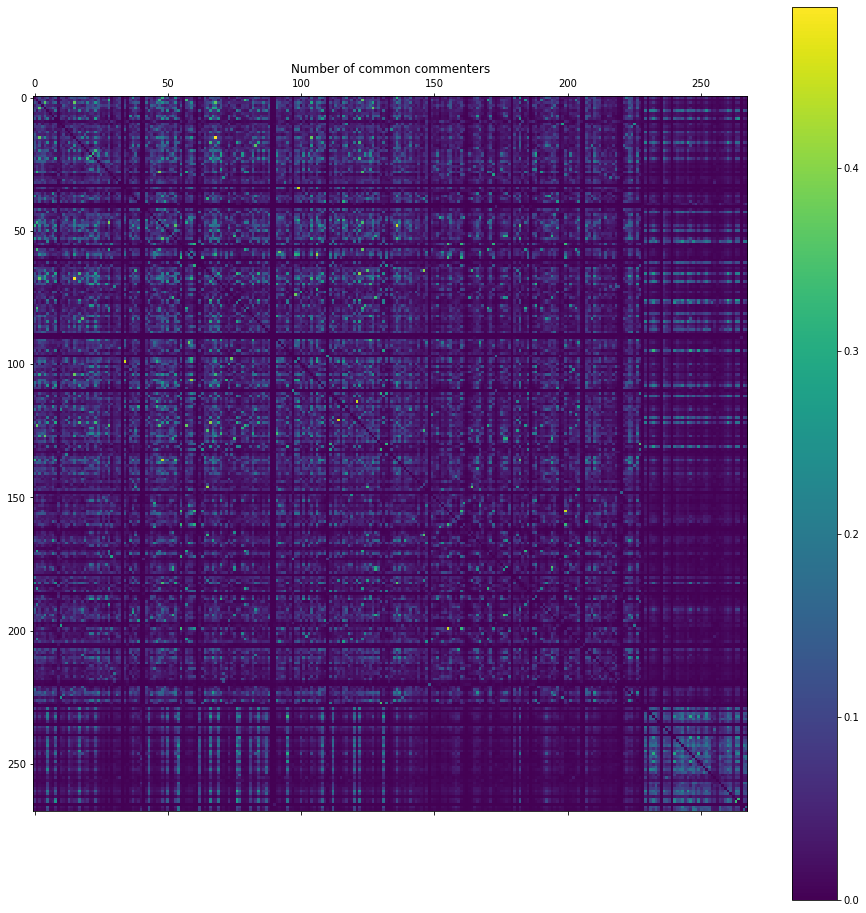

In [112]:
#create symmetric matrix from upper triangular
norm_sim_matrix_english = np.where(norm_sim_matrix_english, norm_sim_matrix_english, norm_sim_matrix_english.T)

# plot log similarity matrix
plt.matshow(norm_sim_matrix_english)
plt.rcParams["figure.figsize"] = (50,50)
plt.colorbar()
plt.title('Number of common commenters')
plt.show()

In [113]:
clustering = skcl.SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_english)
labels_2_clusters_english = clustering.labels_
labels_2_clusters_english

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 1, 0, 0], dtype=int32)

In [114]:
clustering = skcl.SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_english)
labels_3_clusters_english = clustering.labels_
labels_3_clusters_english

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0,
 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1,
 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
 2, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0,
 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2,
 2, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 1, 0, 0], dtype=int32)

In [115]:
clustering = skcl.SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_english)
labels_4_clusters_english = clustering.labels_
labels_4_clusters_english

array([3, 3, 3, 3, 3, 2, 3, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 2, 0, 3, 2,
 3, 0, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0, 0, 3, 0, 0, 0, 2, 2, 0, 3, 3,
 2, 3, 3, 2, 3, 3, 0, 3, 0, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2,
 3, 0, 3, 3, 3, 0, 3, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 3,
 0, 0, 2, 0, 3, 0, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 2,
 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0,
 3, 0, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 0, 3,
 3, 3, 0, 1, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
 3, 0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 0,
 0, 3, 3, 3, 3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
 2, 2, 2, 2], dtype=int32)

In [125]:
cl2 = pd.DataFrame(labels_2_clusters_english).reset_index().rename(columns={0: "two_clust"})
cl3 = pd.DataFrame(labels_3_clusters_english).reset_index().rename(columns={0: "three_clust"})
cl4 = pd.DataFrame(labels_4_clusters_english).reset_index().rename(columns={0: "four_clust"})

cluster_nodes_english = english_nodes_new_indices.merge(cl2, left_on='level_0', right_on='index', how='outer') \
    .merge(cl3, left_on='level_0', right_on='index', how='outer') \
    .merge(cl4, left_on='level_0', right_on='index', how='outer')

cluster_nodes_english = cluster_nodes_english.drop(['index_x', 'index_y'], axis=1).rename(columns={"level_0": "index"})

cluster_nodes_english

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2005-12-16,PlayStation,8960000,11582,604,2.0870,Gaming,414930,1,1,3
1,1,2011-09-25,I AM WILDCAT,7080000,1178,944,2.0870,Gaming,194783,1,1,3
2,2,2010-04-29,PewDiePie,101000000,3956,3,2.0870,Gaming,2443367,1,1,3
3,3,2014-05-27,Jelly,14206967,3651,213,2.0870,Gaming,327582,1,1,3
4,4,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
263,263,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383,0,0,2
264,264,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,2
265,265,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,1,1,2
266,266,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,0,2


In [126]:
cluster_nodes_english.to_csv("english_nodes_clustered.csv", index=False)
english_weighted_new_indices.to_csv("english_edges_clustered.csv", index=False)

# Results of clustering english channels

In [140]:
cluster0 = cluster_nodes_english.query("two_clust == 0")
cluster1 = cluster_nodes_english.query("two_clust == 1")

print(f"""Number of gaming channels in cluster 0 : {len(cluster0.query("category_e == 'Gaming'"))}""")
print(f"""Number of gaming channels in cluster 1 : {len(cluster1.query("category_e == 'Gaming'"))}""")
print(f"""Number of news&politics channels in cluster 1 : {len(cluster0.query("category_e == 'News & Politics'"))}""")
print(f"""Number of news&politics channels in cluster 1 : {len(cluster1.query("category_e == 'News & Politics'"))}""")

Number of gaming channels in cluster 0 : 4
Number of gaming channels in cluster 1 : 189
Number of news&politics channels in cluster 1 : 63
Number of news&politics channels in cluster 1 : 12


--> Divides mostly in gaming vs news&politics

# Cluster news & politics channels

In [5]:
cluster_nodes_english = pd.read_csv("english_nodes_clustered.csv",delimiter=',')
english_weighted_new_indices = pd.read_csv("english_edges_clustered.csv",delimiter=',')

In [6]:
politics_nodes_bad_index = cluster_nodes_english.query("category_e == 'News & Politics'")
politics_nodes_bad_index = politics_nodes_bad_index.drop(['two_clust', 'three_clust', 'four_clust'], axis=1)
politics_nodes_bad_index

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
4,4,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185
5,5,2006-04-08,BBC News,5190000,10459,1531,2.0870,News & Politics,431107
6,6,2012-01-26,Scarce,2800000,1550,4350,2.3540,News & Politics,118092
8,8,2005-12-21,The Young Turks,4470000,37847,1995,2.0995,News & Politics,1017611
13,13,2014-07-11,True Crime Daily,3250000,3830,2945,2.2260,News & Politics,452574
...,...,...,...,...,...,...,...,...,...
263,263,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383
264,264,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
265,265,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
266,266,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


In [7]:
# Delete edges from and to nodes of other category
politics_weighted = english_weighted_new_indices[english_weighted_new_indices['Source'].isin(politics_nodes_bad_index['index'])]
politics_weighted = politics_weighted[politics_weighted['Target'].isin(politics_nodes_bad_index['index'])]
politics_weighted

,Weight,Source,Target
14,0.062062,4,5
19,0.073548,4,6
20,0.033347,5,6
32,0.092162,4,8
33,0.186925,5,8
...,...,...,...
35456,0.036659,262,267
35457,0.072078,263,267
35458,0.063714,264,267
35459,0.000131,265,267


In [8]:
politics_nodes = politics_nodes_bad_index.reset_index(drop=True).reset_index()
politics_nodes

,level_0,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count
0,0,4,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185
1,1,5,2006-04-08,BBC News,5190000,10459,1531,2.0870,News & Politics,431107
2,2,6,2012-01-26,Scarce,2800000,1550,4350,2.3540,News & Politics,118092
3,3,8,2005-12-21,The Young Turks,4470000,37847,1995,2.0995,News & Politics,1017611
4,4,13,2014-07-11,True Crime Daily,3250000,3830,2945,2.2260,News & Politics,452574
...,...,...,...,...,...,...,...,...,...,...
70,70,263,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383
71,71,264,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017
72,72,265,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344
73,73,266,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379


In [9]:
politics_edges = politics_weighted.merge(politics_nodes[['index', 'level_0']], left_on='Source', right_on='index', how='inner')
politics_edges = politics_edges.drop(['index', 'Source'], axis=1).rename(columns={"level_0": "Source"})
politics_edges = politics_edges.merge(politics_nodes[['index', 'level_0']], left_on='Target', right_on='index', how='inner')
politics_edges = politics_edges.drop(['index', 'Target'], axis=1).rename(columns={"level_0": "Target"})

politics_edges

,Weight,Source,Target
0,0.062062,0,1
1,0.073548,0,2
2,0.033347,1,2
3,0.092162,0,3
4,0.186925,1,3
...,...,...,...
2721,0.000244,21,26
2722,0.000140,22,26
2723,0.000078,23,26
2724,0.000055,24,26


In [10]:
norm_sim_matrix_politics = np.zeros([75, 75])
norm_sim_matrix_politics.fill(0)

for index, row in politics_edges.iterrows():
    i = int(row['Source'])
    j = int(row['Target'])
    norm_sim_matrix_politics[i][j] = row['Weight']

print(norm_sim_matrix_politics)

[[0.00000000e+00 6.20615389e-02 7.35477690e-02 ... 4.87929439e-05
  9.72020708e-03 4.66292939e-03]
 [0.00000000e+00 0.00000000e+00 3.33467468e-02 ... 1.84565268e-04
  1.32728420e-01 9.63889451e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.66063303e-04
  1.29234166e-02 5.63757225e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.93674975e-04 1.31380148e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.46449993e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


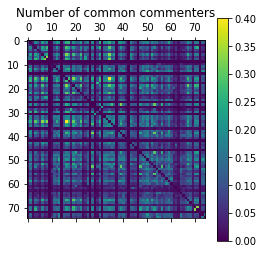

In [11]:
#create symmetric matrix from upper triangular
norm_sim_matrix_politics = np.where(norm_sim_matrix_politics, norm_sim_matrix_politics, norm_sim_matrix_politics.T)

# plot log similarity matrix
plt.matshow(norm_sim_matrix_politics)
plt.rcParams["figure.figsize"] = (50,50)
plt.colorbar()
plt.title('Number of common commenters')
plt.show()

In [12]:
clustering = skcl.SpectralClustering(n_clusters=2, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_politics)
labels_2_clusters_politics = clustering.labels_
labels_2_clusters_politics

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [13]:
clustering = skcl.SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_politics)
labels_3_clusters_politics = clustering.labels_
labels_3_clusters_politics

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0,
 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2,
 0, 0, 0, 2, 0, 0, 0, 2, 2], dtype=int32)

In [14]:
clustering = skcl.SpectralClustering(n_clusters=4, affinity='precomputed', assign_labels='kmeans').fit(norm_sim_matrix_politics)
labels_4_clusters_politics = clustering.labels_
labels_4_clusters_politics

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1,
 1, 1, 1, 1, 3, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1,
 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3,
 1, 1, 1, 3, 1, 1, 3, 3, 3], dtype=int32)

In [15]:
cl2 = pd.DataFrame(labels_2_clusters_politics).reset_index().rename(columns={0: "two_clust"})
cl3 = pd.DataFrame(labels_3_clusters_politics).reset_index().rename(columns={0: "three_clust"})
cl4 = pd.DataFrame(labels_4_clusters_politics).reset_index().rename(columns={0: "four_clust"})

politics_nodes = politics_nodes.merge(cl2, left_on='level_0', right_on='index', how='outer') \
    .merge(cl3, left_on='level_0', right_on='index', how='outer') \
    .merge(cl4, left_on='level_0', right_on='index', how='outer')

politics_nodes = politics_nodes.drop(['index_x', 'index_y'], axis=1).rename(columns={"level_0": "index"})

politics_nodes

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185,0,0,1
1,1,2006-04-08,BBC News,5190000,10459,1531,2.0870,News & Politics,431107,0,0,1
2,2,2012-01-26,Scarce,2800000,1550,4350,2.3540,News & Politics,118092,0,0,1
3,3,2005-12-21,The Young Turks,4470000,37847,1995,2.0995,News & Politics,1017611,0,0,1
4,4,2014-07-11,True Crime Daily,3250000,3830,2945,2.2260,News & Politics,452574,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,2009-09-04,David Pakman Show,730000,20010,21787,2.9455,News & Politics,201383,0,0,1
71,71,2008-04-22,Secular Talk,721000,13278,22209,2.9400,News & Politics,250017,0,0,1
72,72,2015-07-13,ShelowShaqHDOficial,718000,81,22100,2.9420,News & Politics,2344,0,0,3
73,73,2014-08-19,Russia Insight,717926,2872,22747,2.9555,News & Politics,79379,0,2,3


In [218]:
renames = {"index":"Id",
           "name_cc" : "Channel name",
           "category_e" : "Category",
           "subscribers_cc" : "Number of subscribers",
           "videos_cc" : "Number of videos",
           "commentator_count" : "Number of commentator",
           "subscriber_rank_sb" : "Subscriber rank",
           "join_date" : "Date of join",
           "weights_r" : "R_weight"}
politics_nodes.rename(columns=renames).to_csv("politics_nodes.csv", index=False)
#politics_edges.to_csv("politics_edges.csv", index=False)

# Results for politics clustering

In [204]:
politics_nodes = pd.read_csv("politics_nodes.csv")

In [205]:
q = politics_nodes.query("four_clust == 0")
q

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
28,28,2009-08-08,GMA Public Affairs,6920000,20513,677,2.087,News & Politics,36990,1,1,0
31,31,2007-10-29,GMA News,4436635,308522,1596,2.087,News & Politics,12636,1,1,0


In [206]:
q = politics_nodes.query("four_clust == 1")
q

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
0,0,2014-06-16,DramaAlert,5330000,1011,1506,2.0870,News & Politics,1842185,0,0,1
1,1,2006-04-08,BBC News,5190000,10459,1531,2.0870,News & Politics,431107,0,0,1
2,2,2012-01-26,Scarce,2800000,1550,4350,2.3540,News & Politics,118092,0,0,1
3,3,2005-12-21,The Young Turks,4470000,37847,1995,2.0995,News & Politics,1017611,0,0,1
4,4,2014-07-11,True Crime Daily,3250000,3830,2945,2.2260,News & Politics,452574,0,0,1
5,5,2011-10-08,New Rockstars,2340000,1045,5223,2.3970,News & Politics,333090,0,0,1
6,6,2006-09-27,CBS News,1870000,71889,5857,2.4595,News & Politics,540805,0,0,1
7,7,2012-10-09,Inside Edition,6600000,18113,976,2.0870,News & Politics,1591787,0,0,1
8,8,2006-08-07,ABC News,6640000,48869,978,2.0870,News & Politics,1637721,0,0,1
11,11,2007-06-18,Wall Street Journal,1630000,25937,7264,2.5315,News & Politics,130534,0,0,1


In [19]:
q = politics_nodes.query("four_clust == 2")
q

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
9,9,2006-03-09,John Legend,5466913,153,1407,2.087,News & Politics,117,0,2,2


In [208]:
q = politics_nodes.query("four_clust == 3")
q

,index,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights_r,category_e,commentator_count,two_clust,three_clust,four_clust
10,10,2015-06-17,AP Archive,1770000,461923,6059,2.4625,News & Politics,6061,0,2,3
13,13,2006-11-23,Al Jazeera English,3880000,81534,2305,2.1655,News & Politics,136112,0,2,3
14,14,2012-11-19,YouTube Spotlight UK...,2263308,79,5911,2.4595,News & Politics,4103,0,2,3
26,26,2014-02-11,디바제시카Deeva...,1830000,2571,7118,2.5210,News & Politics,1031,0,2,3
37,37,2009-11-30,PBS NewsHour,1380000,26035,9056,2.5430,News & Politics,4554,0,2,3
42,42,2009-08-19,VOA Learning English...,1180000,3347,12557,2.6915,News & Politics,921,0,2,3
46,46,2006-09-18,Associated Press,1040000,129072,14780,2.7865,News & Politics,15,0,2,3
51,51,2009-03-23,The Economist,999000,1812,13820,2.8075,News & Politics,46794,0,2,3
54,54,2007-04-04,FRANCE 24 English,964000,49906,15459,2.8280,News & Politics,88376,0,2,3
55,55,2006-09-19,euronews (in English...,963000,71907,15074,2.7870,News & Politics,31269,0,2,3


--> clusters 0 and 2 are useless \
--> clusters 1 and 3 I can't tell the difference